# Maggot connectome subset

In [1]:
import datetime
import logging
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pymaid
import seaborn as sns
from pkg.data import DATA_PATH
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.plot import set_theme
from pkg.utils import ensure_connected, select_lateral_nodes

FILENAME = "process_maggot"

DISPLAY_FIGS = True

OUT_PATH = DATA_PATH / "processed_split"


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)

## Start Catmaid instance on Virtual Fly Brain

In [2]:

pymaid.CatmaidInstance("https://l1em.catmaid.virtualflybrain.org/", None)
logging.getLogger("pymaid").setLevel(logging.WARNING)
pymaid.clear_cache()

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


## Load the "papers" meta-annotation

In [3]:


def get_indicator_from_annotation(annot_name, filt=None):
    ids = pymaid.get_skids_by_annotation(annot_name.replace("*", "\*"))
    if filt is not None:
        name = filt(annot_name)
    else:
        name = annot_name
    indicator = pd.Series(
        index=ids, data=np.ones(len(ids), dtype=bool), name=name, dtype=bool
    )
    return indicator


annot_df = pymaid.get_annotated("papers")
series_ids = []

for annot_name in annot_df["name"]:
    print(annot_name)
    indicator = get_indicator_from_annotation(annot_name)
    if annot_name == "Imambocus et al":
        indicator.name = "Imambocus et al. 2022"
    series_ids.append(indicator)
annotations = pd.concat(series_ids, axis=1, ignore_index=False).fillna(False)

Zwart et al. 2016
Berck, Khandelwal et al. 2016
Eichler, Li, Litwin-Kumar et al. 2017
Larderet, Fritsch et al. 2017
Ohyama, Schneider-Mizell et al. 2015
Jovanic, Schneider-Mizell et al. 2016
Schlegel et al. 2016
Fushiki et al. 2016
Takagi et al. 2017
Heckscher et al. 2015
Gerhard et al. 2017
Burgos et al 2018
Miroschnikow et al. 2018
Jovanic et al. 2019
Carreira-Rosario, Arzan Zarin, Clark et al. 2018
Zarin, Mark et al. 2019
Mark et al. 2019
Andrade et al. 2019
Tastekin et al. 2018
Eschbach, Fushiki et al. 2020
Eschbach, Fushiki et al. 2020b
Hueckesfeld et al. 2020
Valdes-Aleman et al. 2021


## Get the pairings
This section is not meant to be rerun - it was used to get the subset of pairs from
a forthcoming paper (Winding, Pedigo et al. 2022) which were previously published.

In [4]:

# # TEMP: code to subset the pairs, not to be run again
# pairs = pd.read_csv("bgm/data/maggot/pairs-2021-04-06.csv")

# nodes = []
# pair_id_counter = 0
# for _, row in pairs.iterrows():
#     if (row["leftid"] in annotations.index) and (row["rightid"] in annotations.index):
#         nodes.append(
#             {"node_id": row["leftid"], "pair": pair_id_counter, "hemisphere": "L"}
#         )
#         nodes.append(
#             {"node_id": row["rightid"], "pair": pair_id_counter, "hemisphere": "R"}
#         )
#         pair_id_counter += 1

# nodes = pd.DataFrame(nodes)
# counts = nodes["node_id"].value_counts()
# duplicates = counts[counts > 1].index
# nodes = nodes.set_index("node_id")
# bad_pairs = nodes.loc[duplicates, "pair"]
# nodes = nodes[~nodes["pair"].isin(bad_pairs)]

# nodes.sort_values(["hemisphere", "pair"], inplace=True)
# nodes.to_csv("bgm/data/maggot/nodes.csv")

## Load the pair data
Saved locally, these are just published neurons

In [5]:

raw_path = DATA_PATH / "maggot"

nodes = pd.read_csv(raw_path / "nodes.csv", index_col=0)

## Load their connectivity data

In [6]:

adj_df = pymaid.adjacency_matrix(nodes.index.values)
adj_df = pd.DataFrame(
    data=adj_df.values.astype(int), index=adj_df.index, columns=adj_df.columns
)

## Filter data
Make sure neurons are lateralized and fully connected

In [7]:

adj_df, nodes, removed_nonlateral = select_lateral_nodes(adj_df, nodes)
# then ensure the network is fully connected
adj_df, nodes, removed_lcc = ensure_connected(adj_df, nodes)
# then remove any nodes whose partner got removed by that process
adj_df, nodes, removed_partner_lcc = select_lateral_nodes(adj_df, nodes)
# REPEAT in case this removal of partners causes disconnection
adj_df, nodes, removed_lcc2 = ensure_connected(adj_df, nodes)
adj_df, nodes, removed_partner_lcc2 = select_lateral_nodes(adj_df, nodes)

## Compute some simple statistics

In [8]:
left_index = nodes[nodes["hemisphere"] == "L"].index
right_index = nodes[nodes["hemisphere"] == "R"].index

m_ll = np.count_nonzero(adj_df.loc[left_index, left_index])
m_rr = np.count_nonzero(adj_df.loc[right_index, right_index])
m_lr = np.count_nonzero(adj_df.loc[left_index, right_index])
m_rl = np.count_nonzero(adj_df.loc[right_index, left_index])

m_contra = m_lr + m_rl
m_ipsi = m_ll + m_rr
p_contra = m_contra / (m_ipsi + m_contra)
glue("p_contra", p_contra, form="2.0f%")
print(f"Probability of an edge being a contralateral: {p_contra:.2f}")

Probability of an edge being a contralateral: 0.35


## Examine annotations of the neurons used here

In [9]:

annotations_year = [s.split(" ")[-1] for s in annotations.columns]
annotations_year = pd.Series(data=annotations_year, index=annotations.columns)
annotations_year = annotations_year.sort_index()
annotations_year = annotations_year.sort_values(kind="stable")
annotations = annotations.loc[nodes.index]
annotations = annotations.reindex(columns=annotations_year.index)
annotations = annotations.sort_values(list(annotations.columns), ascending=False)

### Examples of neurons published on twice in the same year

In [10]:
n_pubs = annotations.sum(axis=1)
multi_pub_annotations = annotations[n_pubs > 1]

for idx, row in multi_pub_annotations.iterrows():
    years = annotations_year[row].values

    if (years == years.min()).all():
        print(idx)
        print(annotations_year[row])
        print()

4123145
Mark et al. 2019           2019
Zarin, Mark et al. 2019    2019
dtype: object

11106522
Mark et al. 2019           2019
Zarin, Mark et al. 2019    2019
dtype: object

6578062
Mark et al. 2019           2019
Zarin, Mark et al. 2019    2019
dtype: object

12820178
Mark et al. 2019           2019
Zarin, Mark et al. 2019    2019
dtype: object

2798040
Mark et al. 2019           2019
Zarin, Mark et al. 2019    2019
dtype: object

4542822
Mark et al. 2019           2019
Zarin, Mark et al. 2019    2019
dtype: object

10858401
Mark et al. 2019           2019
Zarin, Mark et al. 2019    2019
dtype: object

12809976
Mark et al. 2019           2019
Zarin, Mark et al. 2019    2019
dtype: object

4386719
Mark et al. 2019           2019
Zarin, Mark et al. 2019    2019
dtype: object

6570401
Mark et al. 2019           2019
Zarin, Mark et al. 2019    2019
dtype: object

16848475
Eschbach, Fushiki et al. 2020    2020
Hueckesfeld et al. 2020          2020
dtype: object

17176866
Eschbach, Fushiki

### Get all papers for which one of our neurons was published for the first time

In [11]:
first_locs = np.argmax(annotations.values, axis=1)
first_published = annotations.columns[first_locs]
used_papers = first_published.unique()
counts = first_published.value_counts()
counts.name = "count"

print("Used papers:")
_ = [print(paper) for paper in used_papers]

Used papers:
Heckscher et al. 2015
Ohyama, Schneider-Mizell et al. 2015
Berck, Khandelwal et al. 2016
Fushiki et al. 2016
Jovanic, Schneider-Mizell et al. 2016
Schlegel et al. 2016
Zwart et al. 2016
Eichler, Li, Litwin-Kumar et al. 2017
Gerhard et al. 2017
Larderet, Fritsch et al. 2017
Takagi et al. 2017
Burgos et al 2018
Carreira-Rosario, Arzan Zarin, Clark et al. 2018
Miroschnikow et al. 2018
Tastekin et al. 2018
Jovanic et al. 2019
Mark et al. 2019
Zarin, Mark et al. 2019
Eschbach, Fushiki et al. 2020
Hueckesfeld et al. 2020
Eschbach, Fushiki et al. 2020b


### Plot the breakdown of first-published neurons by paper

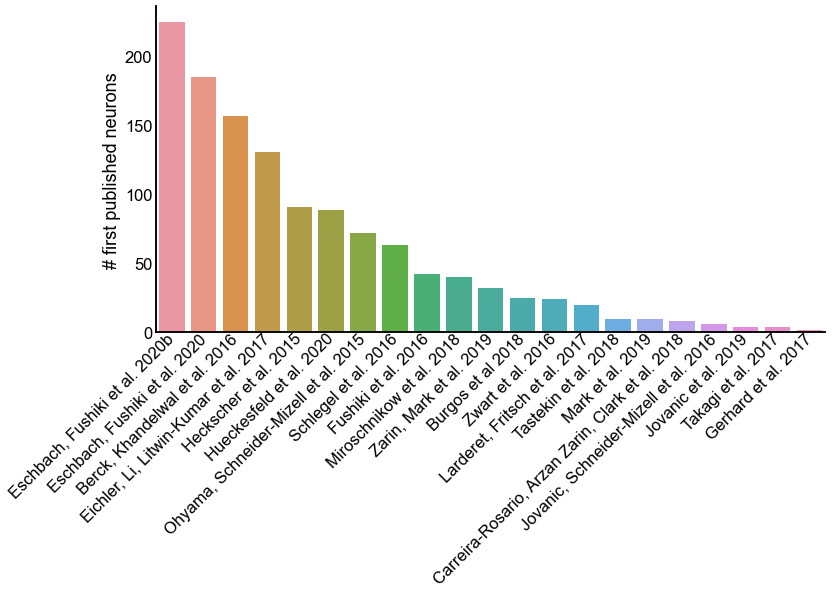

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set(ylabel="# first published neurons")
_ = plt.setp(
    ax.get_xticklabels(),
    rotation=45,
    ha="right",
    va="center",
    rotation_mode="anchor",
)

## Save the finalized network and node metadata

In [13]:
g = nx.from_pandas_adjacency(adj_df, create_using=nx.DiGraph)

nx.write_edgelist(
    g, OUT_PATH / "maggot_subset_edgelist.csv", delimiter=",", data=["weight"]
)

nodes.to_csv(OUT_PATH / "maggot_subset_nodes.csv")

## End

In [14]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:10.460662
Completed at 2022-05-13 13:23:31.066177
